In [6]:
#Needed in general


import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../Scripts')


# import script that has formation channel classification functions:
from PostProcessingScripts import * 


from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import astropy
import seaborn as sns
from seaborn_utility import cmap_from_colour


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

from KDEpy import FFTKDE
from scipy.stats import norm

colors = ['#1f77b4', '#ff7f0e', 'gray']
colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7), adjust_lightness(color=colors[2], amount=1.7)]



In [ ]:
## 

In [18]:
fs=20
def plotHist_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    bins = 10000
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
        
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatio = M2/M1
        
        M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
        separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
        Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
        MassRatioZAMS = M2ZAMS / M1ZAMS 

        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

    
        var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                   'Chirpmass':Chirpmass, 'M1':M1, 'M2':M2, 'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}
        
        
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
        
            ls_ = '-'
            Highlight = False
            if ((mssfr in ['123']) & (BPSmodelName in ['K'])):
                ls_ = ':'
                Highlight = True
            elif  ((mssfr in ['312']) & (BPSmodelName in ['T'])):
                ls_ = '--'
                Highlight = True
            elif ((mssfr in ['231']) & (BPSmodelName in ['O'])):
                ls_ = '-.'
                Highlight = True
                
            
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            
            if Highlight==True:
#                 axe.hist(var_dict[xvar],           bins=bins, weights=w,           cumulative=True, density=True, color=colors[2], histtype='step', lw=4.5, zorder=16, alpha=1,  ls=ls_)
                axe.hist(var_dict[xvar][mask_MRR], bins=bins, weights=w[mask_MRR], cumulative=True, density=True, color=colors[1], histtype='step', lw=4.5, zorder=110, alpha=1, ls=ls_)
                axe.hist(var_dict[xvar][~mask_MRR], bins=bins, weights=w[~mask_MRR], cumulative=True, density=True, color=colors[0], histtype='step', lw=4.5, zorder=110, alpha=1, ls=ls_)

            else:
#                 axe.hist(var_dict[xvar],           bins=bins, weights=w,           cumulative=True, density=True, color=colors_lighter[2], histtype='step', lw=4.5, zorder=6, alpha=1,  ls=ls_)
                axe.hist(var_dict[xvar][mask_MRR], bins=bins, weights=w[mask_MRR], cumulative=True, density=True, color=colors_lighter[1], histtype='step', lw=4.5, zorder=10, alpha=1, ls=ls_)
                axe.hist(var_dict[xvar][~mask_MRR], bins=bins, weights=w[~mask_MRR], cumulative=True, density=True, color=colors_lighter[0], histtype='step', lw=4.5, zorder=10, alpha=1, ls=ls_)
  
 
    # BEAUTIFY: 

    ylabel='CDF'

    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,1)
    if (BPSmodelName=='A'):              
        if (xvar=='MassRatioZAMS'):

            xx = [-100, -50]
#             axe.plot(xx, np.ones_like(xx)*-100,  color=colors_lighter[2], zorder=2, lw=16, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
            axe.plot(xx, np.ones_like(xx)*-100,  color=colors_lighter[1], zorder=2, lw=16, alpha=1, ls='-', label = r'$\textbf{MRR}$')
            axe.plot(xx, np.ones_like(xx)*-100,  color=colors_lighter[0], zorder=2, lw=16, alpha=1, ls='-', label = r'$\textbf{non-MRR}$')
        #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
            ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)

            # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
            xx_q = np.linspace(0,1, 100)
            yy_q = np.linspace(0,1, 100)
            ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
#             ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)

        elif xvar=='separationZAMS':        
            # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
            yy_q = np.linspace(0,1, 100)
            xx_q = np.logspace(-2,3, 100)
            ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
#             ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)

        elif xvar=='M1ZAMS':        
            # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
            xx_q = np.linspace(5,150, 100)
            yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
            yy_q = np.cumsum(yy_q)
            ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
#             ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)

        

    axe.grid(True)
    if xvar=='M1ZAMS':
        _ == layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
    
    else:
        _ == layoutAxesNoYlabel(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
#         axe.set_yticks([])
        axe.set_yticklabels( () ) 
    
        
    
    if xvar=='separationZAMS':
        
        ax.set_xscale('log')
    


    return



now running model  A  for x =  M1ZAMS
now running model  A  for x =  MassRatioZAMS
now running model  A  for x =  separationZAMS
now running model  B  for x =  M1ZAMS
now running model  B  for x =  MassRatioZAMS
now running model  B  for x =  separationZAMS
now running model  C  for x =  M1ZAMS
now running model  C  for x =  MassRatioZAMS
now running model  C  for x =  separationZAMS
now running model  D  for x =  M1ZAMS
now running model  D  for x =  MassRatioZAMS
now running model  D  for x =  separationZAMS
now running model  E  for x =  M1ZAMS
now running model  E  for x =  MassRatioZAMS
now running model  E  for x =  separationZAMS
now running model  F  for x =  M1ZAMS
now running model  F  for x =  MassRatioZAMS
now running model  F  for x =  separationZAMS
now running model  G  for x =  M1ZAMS
now running model  G  for x =  MassRatioZAMS
now running model  G  for x =  separationZAMS
now running model  H  for x =  M1ZAMS
now running model  H  for x =  MassRatioZAMS
now running mo

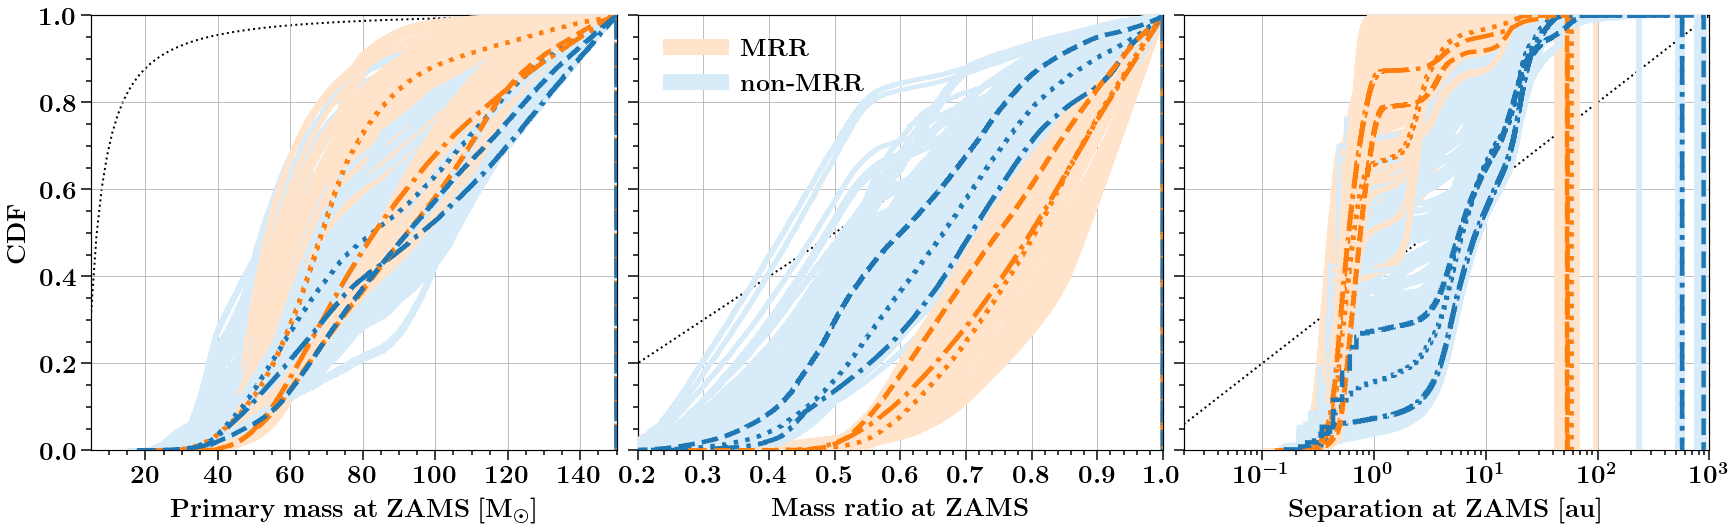

In [19]:
f, axx= plt.subplots(ncols=3,nrows=1,figsize=(29,8))

for BPS in BPSnameslist[:]:
# for BPS in [BPSnameslist[0]]:    
    
    # plot M1ZAMS on the left panel
    xvar='M1ZAMS'    
    plotHist_OtherModels(axe=axx[0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=5, xvar_maxx=150, DCOtype='BBH' ,label_x=r'$\textbf{Primary} \ \textbf{mass} \  \textbf{at} \ \textbf{ZAMS} \ [\rm{M}_{\odot}] $')

    # plot Mass Ratio ZAMS on the left panel
    xvar='MassRatioZAMS'    
    plotHist_OtherModels(axe=axx[1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.2, xvar_maxx=1, DCOtype='BBH' ,label_x=r'$\textbf{Mass} \ \textbf{ratio}  \ \textbf{at} \ \textbf{ZAMS} $')

    xvar='separationZAMS'    
    plotHist_OtherModels(axe=axx[2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.02, xvar_maxx=1000, DCOtype='BBH' ,label_x=r'$\textbf{Separation} \ \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')
    
plt.subplots_adjust(wspace=0.04, hspace=0)#2)


plt.savefig('./CDF_models_multiPanel_ZAMS.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
plt.show()



# ZAMS MULTIPANEL (Figure 3)

In [2]:
fs=20
def plotHist_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
        
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatio = M2/M1
        
        M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
        separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
        Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
        MassRatioZAMS = M2ZAMS / M1ZAMS 

        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

    
        var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                   'Chirpmass':Chirpmass, 'M1':M1, 'M2':M2, 'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}
        
        
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            # make CDF of all BBH systems
            axe.hist(var_dict[xvar], bins=len(var_dict[xvar]), weights=w, cumulative=True, density=True, color=c_BBH, histtype='step', lw=4.5, zorder=6, alpha=1)
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[xvar][mask_MRR], bins=len(var_dict[xvar][mask_MRR]), weights=w[mask_MRR], cumulative=True, density=True, color=c_MRR, histtype='step', lw=4.5, zorder=10, alpha=1, ls='--')

 
    # BEAUTIFY: 

    ylabel='CDF'

    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,1)
                  
    if xvar=='MassRatioZAMS':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{MRR} \ \textbf{BBHs}$')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(0.25, 0.8,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(0,1, 100)
        yy_q = np.linspace(0,1, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)
        
    elif xvar=='separationZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        yy_q = np.linspace(0,1, 100)
        xx_q = np.logspace(-2,3, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)
    
    elif xvar=='M1ZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(5,150, 100)
        yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
        yy_q = np.cumsum(yy_q)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)
                  
        

    axe.grid(True)
    if xvar=='M1ZAMS':
        _ == layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
    
    else:
        _ == layoutAxesNoYlabel(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
#         axe.set_yticks([])
        axe.set_yticklabels( () ) 
    
        
    
    if xvar=='separationZAMS':
        
        ax.set_xscale('log')
    


    return



In [ ]:

for BPS in BPSnameslist[:]:
    
    f, axx= plt.subplots(ncols=3,nrows=1,figsize=(29,8))
    # plot M1ZAMS on the left panel
    xvar='M1ZAMS'    
    plotHist_OtherModels(axe=axx[0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=5, xvar_maxx=150, DCOtype='BBH' ,label_x=r'$\textbf{Primary} \ \textbf{mass} \  \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')

    # plot Mass Ratio ZAMS on the left panel
    xvar='MassRatioZAMS'    
    plotHist_OtherModels(axe=axx[1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.2, xvar_maxx=1, DCOtype='BBH' ,label_x=r'$\textbf{Mass} \ \textbf{ratio}  \ \textbf{at} \ \textbf{ZAMS} $')

    xvar='separationZAMS'    
    plotHist_OtherModels(axe=axx[2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.02, xvar_maxx=1000, DCOtype='BBH' ,label_x=r'$\textbf{Separation} \ \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')
    
    plt.subplots_adjust(wspace=0.04, hspace=0)#2)


    plt.savefig('./CDF_models_' + 'multiPanel' + '_' + BPS + '.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()



# FINAL PROPERTIES 

In [2]:
fs=20
def plotHist_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
        
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
                
        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

        if xvar in ['MassRatioZAMS', 'separationZAMS',  'TotalMassZAMS' , 'M1ZAMS', 'M2ZAMS', 'separationZAMS'  ]:
            M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
            M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
            separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
            Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
            MassRatioZAMS = M2ZAMS / M1ZAMS             
            var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                         'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}   
            
            
        elif xvar in ['Chirp_mass', 'MBH_from_ZAMSM1', 'MBH_from_ZAMSM2',  'M1LVK', 'M2LVK', 'qLVK', 'Total_mass', \
                     'Effective_spin']:
            
            M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
            M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
            # M1 will be the most massive, M2 the least massive compact object. 
            M1LVK, M2LVK = obtainM1BHandM2BHassymetric(m1=M1BH, m2=M2BH) 
            Chirpmass = chirpmass(M1LVK, M2LVK)
            MassRatioLVK = M2LVK/M1LVK
            

            spin = COspin(data_path=path)  # set class 
            spin.setCOMPASData() # reads in the COMPAS DCO parameters 
            spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
            chi_effective = (spinMZAMS1*M1BH) + (spinMZAMS2*M2BH)
            chi_effective = chi_effective/(M1BH+M2BH)
            del spinMZAMS1
            del spinMZAMS2
            del spin            
            
            var_dict = {'Chirp_mass':Chirpmass, 'MBH_from_ZAMSM1':M1BH, 'MBH_from_ZAMSM2':M2BH,\
                        'M1LVK':M1LVK, 'M2LVK':M2LVK, 'qLVK':MassRatioLVK, 'Total_mass':(M1LVK+M2LVK),\
                       'Effective_spin':chi_effective}
            del M1BH
            del M2BH
            
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            # make CDF of all BBH systems
            axe.hist(var_dict[xvar], bins=len(var_dict[xvar]), weights=w, cumulative=True, density=True, color='k', histtype='step', lw=4, zorder=6, alpha=1, ls='-')
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[xvar][mask_MRR], bins=len(var_dict[xvar][mask_MRR]), weights=w[mask_MRR], cumulative=True, density=True, color=c_MRR, histtype='step', lw=5, zorder=10, alpha=1, ls='--')
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[xvar][~mask_MRR], bins=len(var_dict[xvar][~mask_MRR]), weights=w[~mask_MRR], cumulative=True, density=True, color=c_BBH, histtype='step', lw=3, zorder=10, alpha=1, ls='--')

 
    del fdata
    del var_dict

    # BEAUTIFY:     
    ylabel='CDF'
    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,1)
                  
    if xvar=='MassRatioZAMS':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color='k', zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=3, lw=4.5, alpha=1, ls=':', label = r'$\textbf{MRR} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=3, lw=4.5, alpha=1, ls=':', label = r'$\textbf{not} \  \textbf{MRR} \ \textbf{BBHs}$')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(0.25, 0.8,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(0,1, 100)
        yy_q = np.linspace(0,1, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)
        
    elif xvar=='separationZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        yy_q = np.linspace(0,1, 100)
        xx_q = np.logspace(-2,3, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)
    
    elif xvar=='M1ZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(5,150, 100)
        yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
        yy_q = np.cumsum(yy_q)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)
     
    elif xvar=='M1LVK':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color='k', zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{MRR} $')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{not} \  \textbf{MRR} $')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(3, 0.6,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      

    
    axe.grid(True)
    _ = layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 

    
    
#     if (xvar=='M1ZAMS') | (xvar=='M1LVK') | (xvar=='Chirp_mass'):
#         _ = layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
    
#     else:
#         _ = layoutAxesNoYlabel(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
# #         axe.set_yticks([])
#         axe.set_yticklabels( () ) 
    
        
    
    if xvar=='separationZAMS' :
        ax.set_xscale('log')
    elif xvar=='Effective_spin':
#         ax.set_yscale('log') 
        ax.set_ylim(0.5, 1)
        ax.set_xlim(0., .5)
        print()
    

    

    return



now running model  A  for x =  M1LVK
8371398 8371398 8371398


KeyboardInterrupt: 

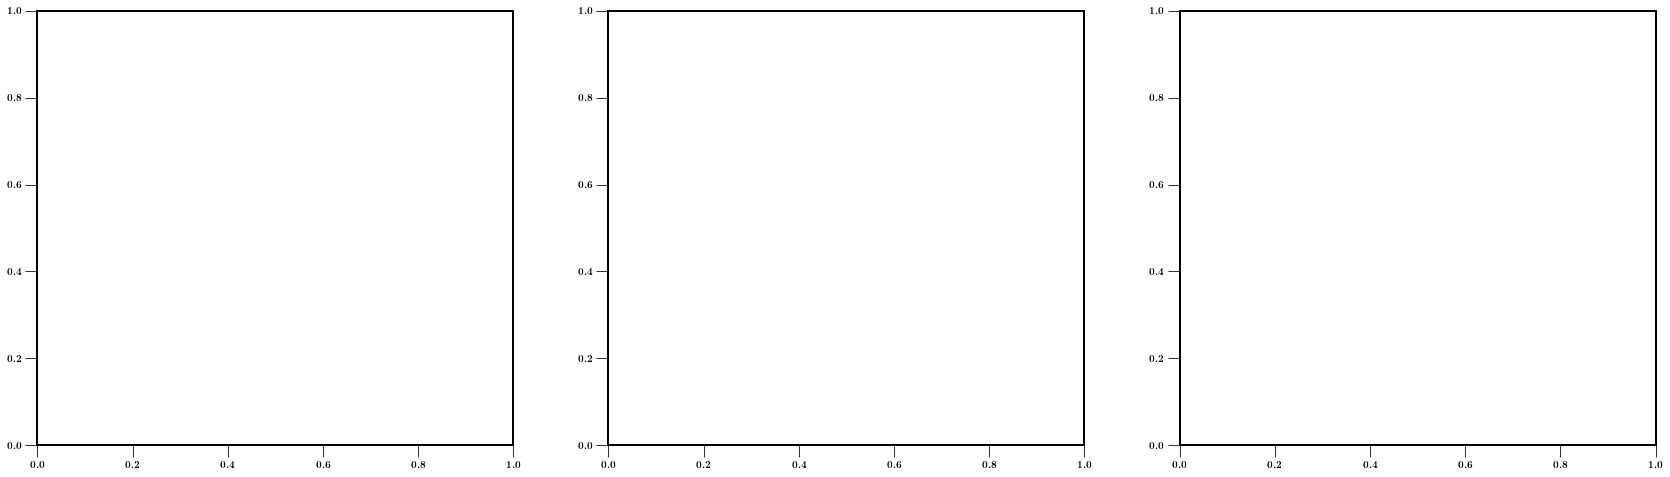

In [28]:

for BPS in BPSnameslist[0:2]:
    
    f, axx= plt.subplots(ncols=3,nrows=1,figsize=(29,8))
    # plot M1ZAMS on the left panel
    xvar, label, xmin, xmax ='M1LVK',  r'$M_{\rm{BH,1}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotHist_OtherModels(axe=axx[0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[0:2], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    # plot Mass Ratio ZAMS on the left panel
    xvar, label, xmin, xmax ='M2LVK', r'$M_{\rm{BH,2}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotHist_OtherModels(axe=axx[1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:2], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='qLVK', r'$\textbf{BBH} \ \textbf{mass} \ \textbf{ratio} \ q  $', 0, 1    
    plotHist_OtherModels(axe=axx[2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:2], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
    plt.subplots_adjust(wspace=0.04, hspace=0)#2)


    plt.savefig('./CDFsFinalMasses/CDF_models_' + 'multiPanel' + '_' + BPS + '.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()



# PLOT CDF 6 panel 

now running model  G  for x =  M1LVK
6338030 6338030 6338030
now running model  G  for x =  M2LVK
6338030 6338030 6338030
now running model  G  for x =  qLVK
6338030 6338030 6338030
at second row
now running model  G  for x =  Chirp_mass
6338030 6338030 6338030
now running model  G  for x =  Total_mass
6338030 6338030 6338030
now running model  G  for x =  Effective_spin
6338030 6338030 6338030



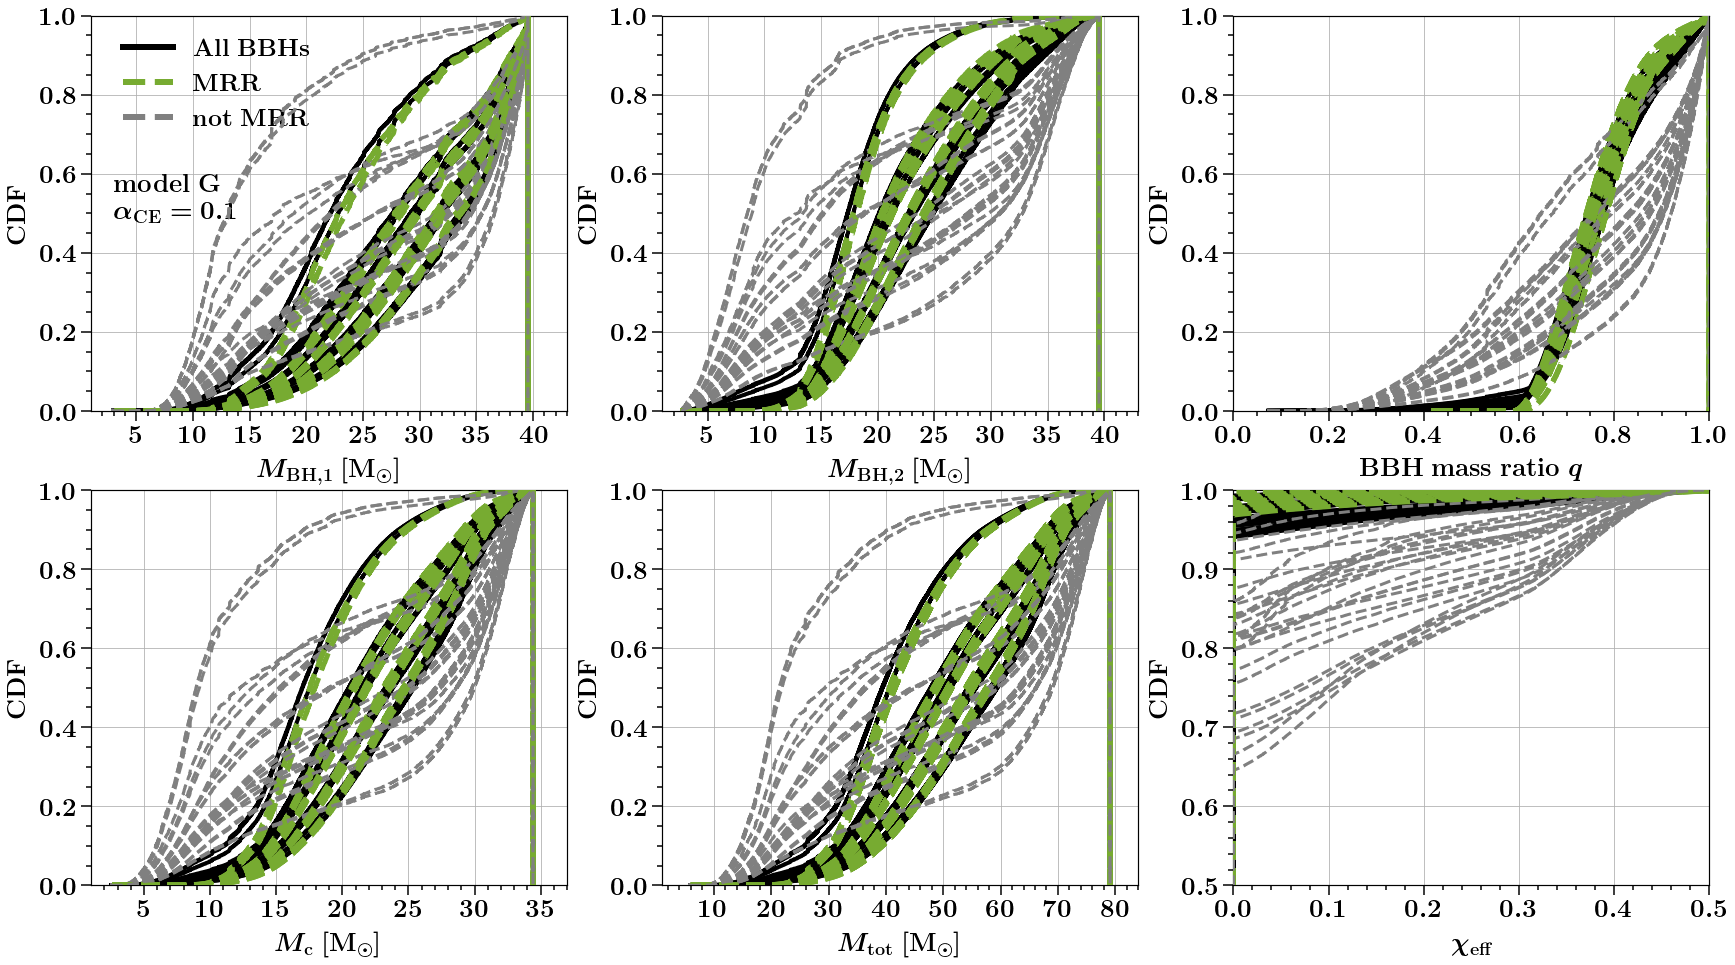

now running model  H  for x =  M1LVK
7958497 7958497 7958497
now running model  H  for x =  M2LVK
7958497 7958497 7958497
now running model  H  for x =  qLVK
7958497 7958497 7958497
at second row
now running model  H  for x =  Chirp_mass
7958497 7958497 7958497
now running model  H  for x =  Total_mass
7958497 7958497 7958497
now running model  H  for x =  Effective_spin
7958497 7958497 7958497



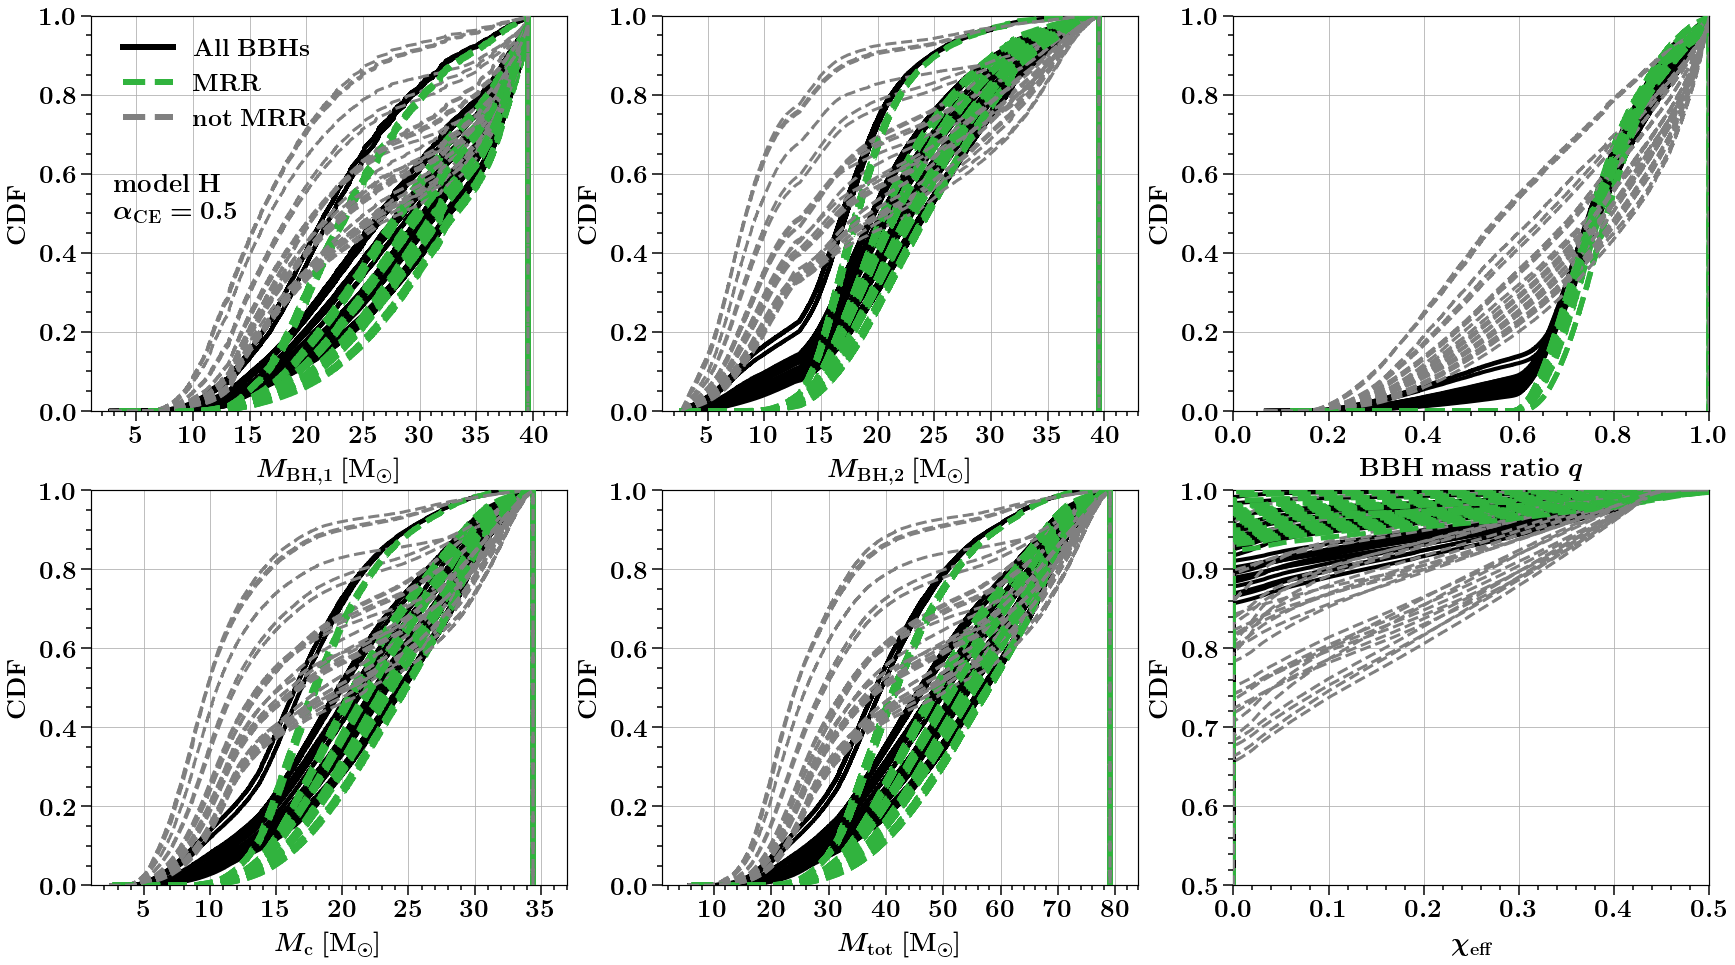

now running model  I  for x =  M1LVK
6212236 6212236 6212236
now running model  I  for x =  M2LVK
6212236 6212236 6212236


In [ ]:

for BPS in BPSnameslist[6:]:
    
    f, axx= plt.subplots(ncols=3,nrows=2,figsize=(29,16))
    # plot M1ZAMS on the left panel
    xvar, label, xmin, xmax ='M1LVK',  r'$M_{\rm{BH,1}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotHist_OtherModels(axe=axx[0,0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='M2LVK', r'$M_{\rm{BH,2}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotHist_OtherModels(axe=axx[0,1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='qLVK', r'$\textbf{BBH} \ \textbf{mass} \ \textbf{ratio} \ q  $', 0, 1    
    plotHist_OtherModels(axe=axx[0,2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
    print('at second row')
    #### second row #####
    xvar, label, xmin, xmax ='Chirp_mass',  r'$M_{\rm{c}} \ [\rm{M}_{\odot}]$', 1, 37    
    plotHist_OtherModels(axe=axx[1,0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='Total_mass', r'$M_{\rm{tot}} \ [\rm{M}_{\odot}]$', 1, 84    
    plotHist_OtherModels(axe=axx[1,1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='Effective_spin', r'$\chi_{\rm{eff}}$', 0., 1    
    plotHist_OtherModels(axe=axx[1,2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
        
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)#2)


    plt.savefig('./CDFsFinalMasses/CDF_models_' + 'DoubleMultiPanel' + '_' + BPS + '.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()



# Make PDF 

In [ ]:
fs=20
def plotPDF_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
        
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1LVK, M2LVK = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
        M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
        Chirpmass = chirpmass(M1LVK, M2LVK)
        MassRatioLVK = M2LVK/M1LVK
        
        M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
        separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
        Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
        MassRatioZAMS = M2ZAMS / M1ZAMS 
        
        spin = COspin(data_path=path)  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
        chi_effective = (spinMZAMS1*M1BH) + (spinMZAMS2*M2BH)
        chi_effective = chi_effective/(fdata['doubleCompactObjects']['M1'][()]+fdata['doubleCompactObjects']['M2'][()])

        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

        if xvar in ['MassRatioZAMS', 'separationZAMS',  'TotalMassZAMS' , 'M1ZAMS', 'M2ZAMS', 'separationZAMS'  ]:
            var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                         'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}            
        elif xvar in [ 'Chirp_mass', 'MBH_from_ZAMSM1', 'MBH_from_ZAMSM2',  'M1LVK', 'M2LVK', 'qLVK', 'Total_mass' , 'Effective_spin' ]:
            var_dict = {'Chirp_mass':Chirpmass, 'MBH_from_ZAMSM1':fdata['doubleCompactObjects']['M1'][()], 'MBH_from_ZAMSM2':fdata['doubleCompactObjects']['M2'][()],\
                        'M1LVK':M1LVK, 'M2LVK':M2LVK, 'qLVK':MassRatioLVK, 'Total_mass':(M1LVK+M2LVK), 'Effective_spin':chi_effective }
        del M1BH
        del M2BH
        # update to incldue weird rejuvenation outliers 
        MRR_mask = (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze())
        
        x_grid = np.linspace(xvar_minn, xvar_maxx, 20)
        x_grid_centers = (x_grid[:-1] + x_grid[1:])/2
 
        
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            
            
            hist_MRR, _ = np.histogram(var_dict[xvar][MRR_mask], x_grid, weights=w[MRR_mask], density=False)
            hist_notMRR, _ = np.histogram(var_dict[xvar][~MRR_mask], x_grid, weights=w[~MRR_mask], density=False)


            axe.fill_between(x_grid_centers, np.zeros_like(hist_MRR), hist_MRR/(np.sum(hist_MRR+hist_notMRR)), color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
            axe.plot(x_grid_centers, (hist_MRR+hist_notMRR)/(np.sum(hist_MRR+hist_notMRR)), 'lightgray', zorder=1, label=r'model %s: Total BBH rate'%BPSmodelName, lw=3)

#             axe.fill_between(x_grid_centers, np.zeros_like(hist_MRR), hist_MRR/(hist_MRR+hist_notMRR), color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
#             axe.fplot(x_grid_centers, hist_MRR/(hist_MRR+hist_notMRR), 'lightgray', zorder=1, label=r'model %s: Total BBH rate'%BPSmodelName)


            
#             # make CDF of all BBH systems
#             axe.hist(var_dict[xvar], bins=len(var_dict[xvar]), weights=w, cumulative=False, density=True, color=c_BBH, histtype='step', lw=4.5, zorder=6, alpha=1)
#             # make CDF of all MRR BBH systems
#             axe.hist(var_dict[xvar][mask_MRR], bins=len(var_dict[xvar][mask_MRR]), weights=w[mask_MRR], cumulative=True, density=True, color=c_MRR, histtype='step', lw=4.5, zorder=10, alpha=1, ls='--')

 
    # BEAUTIFY: 
    
    
    top = max((hist_MRR+hist_notMRR)/(np.sum(hist_MRR+hist_notMRR)))
    
    ylabel='PDF'

    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,top)
                  
    if xvar=='MassRatioZAMS':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{MRR} \ \textbf{BBHs}$')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(0.25, 0.8,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(0,1, 100)
        yy_q = np.linspace(0,1, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)
        
    elif xvar=='separationZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        yy_q = np.linspace(0,1, 100)
        xx_q = np.logspace(-2,3, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)
    
    elif xvar=='M1ZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(5,150, 100)
        yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
        yy_q = np.cumsum(yy_q)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)
                  
    elif xvar=='M1LVK':
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(3, 0.8,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      
        
        
    
    axe.grid(True)
    if (xvar=='M1ZAMS') | (xvar=='M1LVK'):
        _ == layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{PDF}$', setMinor=True, labelpad=10, fontsize=26) 
    
    else:
        _ == layoutAxesNoYlabel(axe, nameX=label_x, nameY=r'$\textbf{PDF}$', setMinor=True, labelpad=10, fontsize=26) 
#         axe.set_yticks([])
        axe.set_yticklabels( () ) 
    
        
    
    if xvar=='separationZAMS':
        
        ax.set_xscale('log')
    


    return



In [ ]:

for BPS in BPSnameslist[0:]:
    
    f, axx= plt.subplots(ncols=3,nrows=1,figsize=(29,8))
    # plot M1ZAMS on the left panel
    xvar, label, xmin, xmax ='M1LVK',  r'$M_{\rm{BH,1}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotPDF_OtherModels(axe=axx[0],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    # plot Mass Ratio ZAMS on the left panel
    xvar, label, xmin, xmax ='M2LVK', r'$M_{\rm{BH,2}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotPDF_OtherModels(axe=axx[1],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='qLVK', r'$\textbf{BBH} \ \textbf{mass} \ \textbf{ratio} \ q  $', 0, 1    
    plotPDF_OtherModels(axe=axx[2],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
    plt.subplots_adjust(wspace=0.04, hspace=0)#2)


    plt.savefig('./PDFsFinalMasses/PDF_models_' + 'multiPanel' + '_' + BPS + '.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()



In [ ]:

for BPS in [BPSnameslist[0]]:
    
    f, axx= plt.subplots(ncols=3,nrows=2,figsize=(29,16))
    # plot M1ZAMS on the left panel
    xvar, label, xmin, xmax ='M1LVK',  r'$M_{\rm{BH,1}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotPDF_OtherModels(axe=axx[0,0],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='M2LVK', r'$M_{\rm{BH,2}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotPDF_OtherModels(axe=axx[0,1],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='qLVK', r'$\textbf{BBH} \ \textbf{mass} \ \textbf{ratio} \ q  $', 0, 1    
    plotPDF_OtherModels(axe=axx[0,2],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
    print('at second row')
    #### second row #####
    xvar, label, xmin, xmax ='Chirp_mass',  r'$M_{\rm{BH,1}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotPDF_OtherModels(axe=axx[0,0],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='Total_mass', r'$M_{\rm{BH,2}} \ [\rm{M}_{\odot}]$', 1, 90    
    plotPDF_OtherModels(axe=axx[0,1],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='Effective_spin', r'$\chi_{\rm{eff}}$', 0, 1    
    plotPDF_OtherModels(axe=axx[0,2],  xvar=xvar, BPSlist=[BPS], SFRDlist=[MSSFRnameslist[0]], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
        
    
    plt.subplots_adjust(wspace=0.04, hspace=0)#2)


    plt.savefig('./PDFsFinalMasses/PDF_models_' + 'DoubleMultiPanel' + '_' + BPS + '.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()



In [ ]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    

    
    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1
        
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()
        
    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH,1}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH,2}} \ [\rm{M}_{\odot}]$',\
           r'$q $'] #,  r'$\log_{10}(t) $']              
    varlist = [Chirpmass, M1, M2, MassRatio]
    
    
    levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    level_labels = [r"$98\%$", r"$90\%$", r"$75\%$", r"$50\%$", r"$25\%$", r"$10\%$", r"$0\%$"]

    
    # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
    mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 
    
    spin = COspin(data_path=path)  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
    
    mask_MRR_and_spin = (mask_MRR ==1) & ((spinMZAMS1 > 0.05) | (spinMZAMS2 > 0.05))
    mask_noMRR_and_spin = (mask_MRR ==0) & ((spinMZAMS1 > 0.05) | (spinMZAMS2 > 0.05))

    fs_l = 20 # label fontsize
    
    c_MRR = 'lightskyblue' 
    c_MRR_spin = 'orange'
    c_noMRR_spin = 'limegreen'
    
    LEGEND = True 
    
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 55)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='k', lw=3, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='gray', zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][mask_MRR], bins=nrbins, weights=w[mask_MRR])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=c_MRR, lw=3, zorder=4)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_MRR, zorder=3, alpha=0.3)
                
#                 hist, bin_edges = np.histogram(varlist[jj][mask_MRR_and_spin], bins=nrbins, weights=w[mask_MRR_and_spin])
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color=c_MRR_spin, lw=3, zorder=4)  
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_MRR_spin, zorder=3, alpha=0.3)

#                 hist, bin_edges = np.histogram(varlist[jj][mask_noMRR_and_spin], bins=nrbins, weights=w[mask_noMRR_and_spin])
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color=c_noMRR_spin, lw=3, zorder=3)  
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_noMRR_spin, zorder=3, alpha=0.3)
                
                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,1)
#                 if param_x== r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 27)
#                 if param_x==  r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 6.2)
                    

                    

                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)
                # cut axes for chirp and MBH mass 
#                 if param_x==  r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 27)
#                 if param_x== r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 6.2)
#                 if param_y==  r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_ylim(ii_minn, 27)
#                 if param_y==r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_ylim(ii_minn, 6.2)                
                
                x = varlist[jj] #np.linspace(0,1,100)
                y = np.ones_like(varlist[jj])
                print(np.shape(varlist[jj]))
                print(np.shape(x))
                N = 1000#  len(varlist[jj])

#                 sns.kdeplot(x=varlist[jj][0:N], y=varlist[ii][0:N], weights=w[0:N], ax=ax[ii, jj],  color='k', shade=True, levels=levels, bw_method=0.7, zorder=9)
                ax[ii,jj].scatter(varlist[jj][0:N], varlist[ii][0:N], s=140*w[0:N], color='k', zorder=4)
                
                ax[ii,jj].scatter(varlist[jj][mask_MRR], varlist[ii][mask_MRR], s=140*w[mask_MRR], color=c_MRR, zorder=10)
#                 ax[ii,jj].scatter(varlist[jj][mask_MRR_and_spin], varlist[ii][mask_MRR_and_spin], s=140*w[mask_MRR_and_spin], color=c_MRR_spin, zorder=11)
#                 ax[ii,jj].scatter(varlist[jj][mask_noMRR_and_spin], varlist[ii][mask_noMRR_and_spin], s=140*w[mask_noMRR_and_spin], color=c_noMRR_spin, zorder=10)
                

#                 sns.kdeplot(x=varlist[jj][0:], y=varlist[ii][0:], weights=w[0:], ax=ax[ii, jj],  color='gray', shade=True, levels=levels, bw_method=0.3, zorder=9)
#                 ax[ii,jj].scatter(varlist[jj][0:], varlist[ii][0:], s=140*w[0:], color='gray', zorder=4)
                
#                 ax[ii,jj].scatter(varlist[jj][mask_MRR], varlist[ii][mask_MRR], s=140*w[mask_MRR], color=c_MRR, zorder=10)
#                 ax[ii,jj].scatter(varlist[jj][mask_MRR_and_spin], varlist[ii][mask_MRR_and_spin], s=140*w[mask_MRR_and_spin], color=c_MRR_spin, zorder=11)
#                 ax[ii,jj].scatter(varlist[jj][mask_noMRR_and_spin], varlist[ii][mask_noMRR_and_spin], s=140*w[mask_noMRR_and_spin], color=c_noMRR_spin, zorder=10)
                
                if (ii==(len(var)-1)):
                    print(ii)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 

    
    # LEGENDS 
    cmap = cmap_from_colour('gray')
    scatter = ax[0,0].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = ax[1,2].inset_axes([0.25, 0.5, 1.5, 0.18])
    cbar = f.colorbar(scatter, ax=ax[0,1], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(level_labels)
    cbar.ax.tick_params(labelsize=26)                    

    ax[1,2].annotate('All BBHs', xy=(1.0, 0.72), xycoords="axes fraction",
                     fontsize=fs+10, color="black", ha="center", va="bottom")                     
                    
    xx = [-100, -50]
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='gray', zorder=2, alpha=0.3, label=r'All BBHs')
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_MRR, zorder=2, alpha=0.3, label = r'MRR')
#     ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_MRR_spin, zorder=2, alpha=0.3, label = r'MRR, spin $> 0.05$')
#     ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_noMRR_spin, zorder=2, alpha=0.3, label = r'no MRR, spin $> 0.05$')
    ax[2,3].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)         
    ax[2,3].set_xlim(100,200)
    ax[2,3].set_ylim(100,200)

                    
                    
    return 





In [ ]:
labellist=[r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$m_{\rm{BH}} \ [M_{\odot}]$', r'$m_{\rm{BH}} \ [M_{\odot}]$',\
           r'$q $'] #,  r'$\log_{10}(t) $']     

f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'
plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
plt.savefig('./Scatter_Final_MRR_det' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()


In [ ]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    

    
    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1
        
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()
        
    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
           r'$q $'] #,  r'$\log_{10}(t) $']              
    varlist = [Chirpmass, M1, M2, MassRatio]
    
    
    levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    level_labels = [r"$98\%$", r"$90\%$", r"$75\%$", r"$50\%$", r"$25\%$", r"$10\%$", r"$0\%$"]

    
    # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
    mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 
    
    spin = COspin(data_path=path)  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
    
    mask_MRR_and_spin = (mask_MRR ==1) & ((spinMZAMS1 > 0.05) | (spinMZAMS2 > 0.05))
    mask_noMRR_and_spin = (mask_MRR ==0) & ((spinMZAMS1 > 0.05) | (spinMZAMS2 > 0.05))

    fs_l = 20 # label fontsize
    
    c_MRR = 'lightskyblue' 
    c_MRR_spin = 'orange'
    c_noMRR_spin = 'limegreen'
    
    LEGEND = True 
    
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 55)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='gray', lw=3, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='k', zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][mask_MRR], bins=nrbins, weights=w[mask_MRR])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=c_MRR, lw=3, zorder=4)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_MRR, zorder=3, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][mask_MRR_and_spin], bins=nrbins, weights=w[mask_MRR_and_spin])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=c_MRR_spin, lw=3, zorder=4)  
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_MRR_spin, zorder=3, alpha=0.3)

                hist, bin_edges = np.histogram(varlist[jj][mask_noMRR_and_spin], bins=nrbins, weights=w[mask_noMRR_and_spin])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=c_noMRR_spin, lw=3, zorder=3)  
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_noMRR_spin, zorder=3, alpha=0.3)
                
                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,1)
#                 if param_x== r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 27)
#                 if param_x==  r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 6.2)
                    

                    

                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)
                # cut axes for chirp and MBH mass 
#                 if param_x==  r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 27)
#                 if param_x== r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 6.2)
#                 if param_y==  r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_ylim(ii_minn, 27)
#                 if param_y==r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_ylim(ii_minn, 6.2)                
                
                x = varlist[jj] #np.linspace(0,1,100)
                y = np.ones_like(varlist[jj])
                print(np.shape(varlist[jj]))
                print(np.shape(x))
                N = 1000#  len(varlist[jj])

#                 sns.kdeplot(x=varlist[jj][0:N], y=varlist[ii][0:N], weights=w[0:N], ax=ax[ii, jj],  color='k', shade=True, levels=levels, bw_method=1, zorder=9)
                ax[ii,jj].scatter(varlist[jj][0:N], varlist[ii][0:N], s=140*w[0:N], color='gray', zorder=4)
                
                ax[ii,jj].scatter(varlist[jj][mask_MRR], varlist[ii][mask_MRR], s=140*w[mask_MRR], color=c_MRR, zorder=10)
                ax[ii,jj].scatter(varlist[jj][mask_MRR_and_spin], varlist[ii][mask_MRR_and_spin], s=140*w[mask_MRR_and_spin], color=c_MRR_spin, zorder=12)
                ax[ii,jj].scatter(varlist[jj][mask_noMRR_and_spin], varlist[ii][mask_noMRR_and_spin], s=140*w[mask_noMRR_and_spin], color=c_noMRR_spin, zorder=11)
                

#                 sns.kdeplot(x=varlist[jj][0:], y=varlist[ii][0:], weights=w[0:], ax=ax[ii, jj],  color='gray', shade=True, levels=levels, bw_method=0.3, zorder=9)
#                 ax[ii,jj].scatter(varlist[jj][0:], varlist[ii][0:], s=140*w[0:], color='gray', zorder=4)
                
#                 ax[ii,jj].scatter(varlist[jj][mask_MRR], varlist[ii][mask_MRR], s=140*w[mask_MRR], color=c_MRR, zorder=10)
#                 ax[ii,jj].scatter(varlist[jj][mask_MRR_and_spin], varlist[ii][mask_MRR_and_spin], s=140*w[mask_MRR_and_spin], color=c_MRR_spin, zorder=11)
#                 ax[ii,jj].scatter(varlist[jj][mask_noMRR_and_spin], varlist[ii][mask_noMRR_and_spin], s=140*w[mask_noMRR_and_spin], color=c_noMRR_spin, zorder=10)
                
                if (ii==(len(var)-1)):
                    print(ii)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 

    
    # LEGENDS 
    cmap = cmap_from_colour('gray')
    scatter = ax[0,0].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = ax[1,2].inset_axes([0.25, 0.5, 1.5, 0.18])
    cbar = f.colorbar(scatter, ax=ax[0,1], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(level_labels)
    cbar.ax.tick_params(labelsize=26)                    

    ax[1,2].annotate('All BBHs', xy=(1.0, 0.72), xycoords="axes fraction",
                     fontsize=fs+10, color="black", ha="center", va="bottom")                     
                    
    xx = [-100, -50]
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='gray', zorder=2, alpha=0.3, label=r'All BBHs')
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_MRR, zorder=2, alpha=0.3, label = r'MRR')
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_MRR_spin, zorder=2, alpha=0.3, label = r'MRR, spin $> 0.05$')
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_noMRR_spin, zorder=2, alpha=0.3, label = r'no MRR, spin $> 0.05$')
    ax[2,3].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)                    
    ax[2,3].set_xlim(100,200)
    ax[2,3].set_ylim(100,200)
                    
                    
labellist=[r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$m_{\rm{BH}} \ [M_{\odot}]$', r'$m_{\rm{BH}} \ [M_{\odot}]$',\
           r'$q $'] #,  r'$\log_{10}(t) $']     

f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'
plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
plt.savefig('./Scatter_Final_kde_det' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()






# ZAMS

In [ ]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    

    
    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1
        
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()
        
    labellist=[ r'$m_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$m_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
           r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$'] #,  r'$\log_{10}(t) $']      
    
    
    
    M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    separationInitial = np.log10(fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
    Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
    massRatio = M2ZAMS / M1ZAMS 
    
    varlist = [M1ZAMS, M2ZAMS, separationInitial, massRatio]
    
    
    levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    level_labels = [r"$98\%$", r"$90\%$", r"$75\%$", r"$50\%$", r"$25\%$", r"$10\%$", r"$0\%$"]

    
    # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
    mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 
    
    spin = COspin(data_path=path)  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
    
    mask_MRR_and_spin = (mask_MRR ==1) & ((spinMZAMS1 > 0.05) | (spinMZAMS2 > 0.05))
    mask_noMRR_and_spin = (mask_MRR ==0) & ((spinMZAMS1 > 0.05) | (spinMZAMS2 > 0.05))

    fs_l = 20 # label fontsize
    
    c_MRR = 'lightskyblue' 
    c_MRR_spin = 'orange'
    c_noMRR_spin = 'limegreen'
    
    LEGEND = True 
    
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 55)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='gray', lw=3, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='k', zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][mask_MRR], bins=nrbins, weights=w[mask_MRR])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=c_MRR, lw=3, zorder=4)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_MRR, zorder=3, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][mask_MRR_and_spin], bins=nrbins, weights=w[mask_MRR_and_spin])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=c_MRR_spin, lw=3, zorder=4)  
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_MRR_spin, zorder=3, alpha=0.3)

                hist, bin_edges = np.histogram(varlist[jj][mask_noMRR_and_spin], bins=nrbins, weights=w[mask_noMRR_and_spin])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=c_noMRR_spin, lw=3, zorder=3)  
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_noMRR_spin, zorder=3, alpha=0.3)
                
                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,1)
#                 if param_x== r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 27)
#                 if param_x==  r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 6.2)
                    

                    

                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)
                # cut axes for chirp and MBH mass 
#                 if param_x==  r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 27)
#                 if param_x== r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 6.2)
#                 if param_y==  r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_ylim(ii_minn, 27)
#                 if param_y==r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_ylim(ii_minn, 6.2)                
                
                x = varlist[jj] #np.linspace(0,1,100)
                y = np.ones_like(varlist[jj])
                print(np.shape(varlist[jj]))
                print(np.shape(x))
                N = 1000#  len(varlist[jj])

#                 sns.kdeplot(x=varlist[jj][0:N], y=varlist[ii][0:N], weights=w[0:N], ax=ax[ii, jj],  color='k', shade=True, levels=levels, bw_method=1, zorder=9)
                ax[ii,jj].scatter(varlist[jj][0:], varlist[ii][0:], s=140*w[0:], color='gray', zorder=4)
                
                ax[ii,jj].scatter(varlist[jj][mask_MRR], varlist[ii][mask_MRR], s=140*w[mask_MRR], color=c_MRR, zorder=10)
                ax[ii,jj].scatter(varlist[jj][mask_MRR_and_spin], varlist[ii][mask_MRR_and_spin], s=140*w[mask_MRR_and_spin], color=c_MRR_spin, zorder=12)
                ax[ii,jj].scatter(varlist[jj][mask_noMRR_and_spin], varlist[ii][mask_noMRR_and_spin], s=140*w[mask_noMRR_and_spin], color=c_noMRR_spin, zorder=11)
                

#                 sns.kdeplot(x=varlist[jj][0:], y=varlist[ii][0:], weights=w[0:], ax=ax[ii, jj],  color='gray', shade=True, levels=levels, bw_method=0.3, zorder=9)
#                 ax[ii,jj].scatter(varlist[jj][0:], varlist[ii][0:], s=140*w[0:], color='gray', zorder=4)
                
#                 ax[ii,jj].scatter(varlist[jj][mask_MRR], varlist[ii][mask_MRR], s=140*w[mask_MRR], color=c_MRR, zorder=10)
#                 ax[ii,jj].scatter(varlist[jj][mask_MRR_and_spin], varlist[ii][mask_MRR_and_spin], s=140*w[mask_MRR_and_spin], color=c_MRR_spin, zorder=11)
#                 ax[ii,jj].scatter(varlist[jj][mask_noMRR_and_spin], varlist[ii][mask_noMRR_and_spin], s=140*w[mask_noMRR_and_spin], color=c_noMRR_spin, zorder=10)
                
                if (ii==(len(var)-1)):
                    print(ii)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 

    
    # LEGENDS 
    cmap = cmap_from_colour('gray')
    scatter = ax[0,0].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = ax[1,2].inset_axes([0.25, 0.5, 1.5, 0.18])
    cbar = f.colorbar(scatter, ax=ax[0,1], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(level_labels)
    cbar.ax.tick_params(labelsize=26)                    

    ax[1,2].annotate('All BBHs', xy=(1.0, 0.72), xycoords="axes fraction",
                     fontsize=fs+10, color="black", ha="center", va="bottom")                     
                    
    xx = [-100, -50]
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='gray', zorder=2, alpha=0.3, label=r'All BBHs')
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_MRR, zorder=2, alpha=0.3, label = r'MRR')
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_MRR_spin, zorder=2, alpha=0.3, label = r'MRR, spin $> 0.05$')
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_noMRR_spin, zorder=2, alpha=0.3, label = r'no MRR, spin $> 0.05$')
    ax[2,3].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)                    
    ax[2,3].set_xlim(100,200)
    ax[2,3].set_ylim(100,200)
                    
  

f, ax= plt.subplots(ncols=4,nrows=4,figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(4), "height_ratios":2*np.ones(4)})

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'
plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
plt.savefig('./Scatter_ZAMS_kde_det' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()






In [ ]:
fs=20
def plotHist_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
        
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatio = M2/M1
        
        M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
        separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
        Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
        MassRatioZAMS = M2ZAMS / M1ZAMS 

        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

    
        var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                   'Chirpmass':Chirpmass, 'M1':M1, 'M2':M2, 'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}
        
        
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            # make CDF of all BBH systems
            axe.hist(var_dict[xvar], bins=len(var_dict[xvar]), weights=w, cumulative=True, density=True, color=c_BBH, histtype='step', lw=4.5, zorder=6, alpha=1)
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[xvar][mask_MRR], bins=len(var_dict[xvar][mask_MRR]), weights=w[mask_MRR], cumulative=True, density=True, color=c_MRR, histtype='step', lw=4.5, zorder=10, alpha=1, ls='--')

 
    # BEAUTIFY: 

    ylabel='CDF'

    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,1)
                  
    if xvar=='MassRatioZAMS':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{MRR} \ \textbf{BBHs}$')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(0.25, 0.8,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(0,1, 100)
        yy_q = np.linspace(0,1, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)
        
    elif xvar=='separationZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        yy_q = np.linspace(0,1, 100)
        xx_q = np.logspace(-2,3, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)
    
    elif xvar=='M1ZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(5,150, 100)
        yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
        yy_q = np.cumsum(yy_q)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)
                  
        

    axe.grid(True)
    if xvar=='M1ZAMS':
        _ == layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
    
    else:
        _ == layoutAxesNoYlabel(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
#         axe.set_yticks([])
        axe.set_yticklabels( () ) 
    
        
    
    if xvar=='separationZAMS':
        
        ax.set_xscale('log')
    


    return



In [ ]:






for BPS in BPSnameslist[-3:]:
    
    f, axx= plt.subplots(ncols=3,nrows=1,figsize=(29,8))
    # plot M1ZAMS on the left panel
    xvar='M1ZAMS'    
    plotHist_OtherModels(axe=axx[0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=5, xvar_maxx=150, DCOtype='BBH' ,label_x=r'$\textbf{Primary} \ \textbf{mass} \  \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')

    # plot Mass Ratio ZAMS on the left panel
    xvar='MassRatioZAMS'    
    plotHist_OtherModels(axe=axx[1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.2, xvar_maxx=1, DCOtype='BBH' ,label_x=r'$\textbf{Mass} \ \textbf{ratio}  \ \textbf{at} \ \textbf{ZAMS} $')

    xvar='separationZAMS'    
    plotHist_OtherModels(axe=axx[2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.02, xvar_maxx=1000, DCOtype='BBH' ,label_x=r'$\textbf{Separation} \ \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')
    
    plt.subplots_adjust(wspace=0.04, hspace=0)#2)


    plt.savefig('./CDF_models_' + 'multiPanel' + '_' + BPS + '.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()



In [ ]:
A=1

In [ ]:
                    



xvar='separationZAMS'

for BPS in BPSnameslist[:]:
    f, ax= plt.subplots(ncols=1,nrows=1,figsize=(10,8))
    plotHist_OtherModels(axe=ax,  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.01, xvar_maxx=1000, DCOtype='BBH' ,label_x=r'$\textbf{Separation} \ \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)

    plt.savefig('./CDF_models_' + xvar + '_' + BPS + '.png', transparent=False, bbox_inches="tight")
    # plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()


    
    
    
    
    

In [ ]:
                    



xvar='M1ZAMS'

for BPS in BPSnameslist[:]:
    f, ax= plt.subplots(ncols=1,nrows=1,figsize=(10,8))
    plotHist_OtherModels(axe=ax,  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:2], xvar_minn=5, xvar_maxx=150, DCOtype='BBH' ,label_x=r'$\textbf{Primary} \ \textbf{mass} \ \textbf{at} \ \textbf{ZAMS} \ [\rm{M}_{\odot}] $')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)

    plt.savefig('./CDF_models_' + xvar + '_' + BPS + '.png', transparent=False, bbox_inches="tight")
    # plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()


    
    
    
    
    

In [ ]:

# start figure 
f, ax= plt.subplots(ncols=1,nrows=1,figsize=(16,10))

# we want the ZAMS mass ratio
xvar='MassRatioZAMS'
# plot the CDFs 
plotHist_OtherModels(axe=ax,  xvar=xvar, BPSlist=BPSnameslist[:], SFRDlist=MSSFRnameslist[:10], xvar_minn=0.2, xvar_maxx=1, DCOtype='BBH' ,label_x=r'$\textbf{Mass} \ \textbf{ratio} \ \textbf{at} \ \textbf{ZAMS}  $')


# layout and save figure
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
plt.savefig('./CDF_models_' + xvar + '.png', transparent=False, bbox_inches="tight") # save the figure 
plt.show()





In [ ]:
                    



xvar='MassRatioZAMS'

for BPS in BPSnameslist[0:2]:
    f, ax= plt.subplots(ncols=1,nrows=1,figsize=(10,10))
    plotHist_OtherModels(axe=ax,  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.2, xvar_maxx=1, DCOtype='BBH' ,label_x=r'$\textbf{Mass} \ \textbf{ratio} \ \textbf{at} \ \textbf{ZAMS}  $')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)

    plt.savefig('./CDF_models_' + xvar + '_' + BPS + '.png', transparent=False, bbox_inches="tight")
    # plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()



In [ ]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    

    
    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1
        
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()
        
    labellist=[ r'$m_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$m_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
           r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$'] #,  r'$\log_{10}(t) $']      
    
    
    
    M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    separationInitial = np.log10(fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
    Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
    massRatio = M2ZAMS / M1ZAMS 
    
    varlist = [M1ZAMS, M2ZAMS, separationInitial, massRatio]
    
    
    levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    level_labels = [r"$98\%$", r"$90\%$", r"$75\%$", r"$50\%$", r"$25\%$", r"$10\%$", r"$0\%$"]

    
    # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
    mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 
    
    spin = COspin(data_path=path)  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
    
    mask_MRR_and_spin = (mask_MRR ==1) & ((spinMZAMS1 > 0.05) | (spinMZAMS2 > 0.05))
    mask_noMRR_and_spin = (mask_MRR ==0) & ((spinMZAMS1 > 0.05) | (spinMZAMS2 > 0.05))

    fs_l = 20 # label fontsize
    
    c_MRR = 'lightskyblue' 
    c_MRR_spin = 'orange'
    c_noMRR_spin = 'limegreen'
    
    LEGEND = True 
    
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 55)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.sum(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='gray', lw=3, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='k', zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][mask_MRR], bins=nrbins, weights=w[mask_MRR])
                yy = hist / np.sum(hist) # normalize to 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=c_MRR, lw=3, zorder=4)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=c_MRR, zorder=3, alpha=0.3)
                

                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,0.2)


                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)          
                
                x = varlist[jj] #np.linspace(0,1,100)
                y = np.ones_like(varlist[jj])
                print(np.shape(varlist[jj]))
                print(np.shape(x))
                N = 1000#  len(varlist[jj])

#                 ax[ii,jj].scatter(varlist[jj][0:], varlist[ii][0:], s=140*w[0:], color='gray', zorder=4)
#                 ax[ii,jj].scatter(varlist[jj][mask_MRR], varlist[ii][mask_MRR], s=140*w[mask_MRR], color=c_MRR, zorder=10)

                
                if (ii==(len(var)-1)):
                    print(ii)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 

    
    # LEGENDS 
    cmap = cmap_from_colour('gray')
    scatter = ax[0,0].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = ax[1,2].inset_axes([0.25, 0.5, 1.5, 0.18])
    cbar = f.colorbar(scatter, ax=ax[0,1], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(level_labels)
    cbar.ax.tick_params(labelsize=26)                    

    ax[1,2].annotate('All BBHs', xy=(1.0, 0.72), xycoords="axes fraction",
                     fontsize=fs+10, color="black", ha="center", va="bottom")                     
                    
    xx = [-100, -50]
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='gray', zorder=2, alpha=0.3, label=r'All BBHs')
    ax[2,3].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color=c_MRR, zorder=2, alpha=0.3, label = r'MRR')
    ax[2,3].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)                    
    ax[2,3].set_xlim(100,200)
    ax[2,3].set_ylim(100,200)
    return 

                    
  


## 



for model in BPSnameslist:
    f, ax= plt.subplots(ncols=4,nrows=4,figsize=(20,20), 
                      gridspec_kw={"width_ratios":1.5*np.ones(4), "height_ratios":2*np.ones(4)})
 
    mssfr = '112' # mssfr that matches LIGO observed rates.

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)

    plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
    plt.savefig('./Scatter_simple_ZAMS_kde_det' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
    plt.show()






In [ ]:
print(BPSnameslist)